### Open Exploration for the Base Case
# Introduction
This notebook presents our open exploration of the base case, where no policies have been implemented. We assess 10,000 scenarios against this policy by employing Latin Hypercube Sampling (LHS). LHS is advantageous as it keeps track of the previously sampled points, enabling us to achieve a broad coverage across the uncertainty ranges.

Essentially, the following analysis provides insights into the behavior of the IJsseldelta when no actions are taken, as visualized through data. Moreover, we utilize scenario discovery techniques to examine the uncertainties that contribute to the most unfavorable outcomes (Kwakkel, Auping & Pruyt, 2012). Specifically, we employ PRIM and CART for this purpose.

# Imports
The only import thats notably different from the "standard" ones aside from all EMA related ones, is the pickle import to speed data storage up

In [6]:
#load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from ema_workbench import (
    Model,
    Policy,
    ema_logging,
    SequentialEvaluator,
    MultiprocessingEvaluator,
    Samplers,
)
from ema_workbench.analysis import prim, cart

from problem_formulation import get_model_for_problem_formulation

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

# Open Exploration

First, the model is initialized, using problem formulation 5.

In [8]:
# initiate model
dike_model, planning_steps = get_model_for_problem_formulation(5)

Then, a reference policy is initialized, in which all policy variables are set to 0.

In [9]:
# set reference policy as all 0's
reference = Policy("0_policy", **{l.name: 0 for l in dike_model.levers})

This is the one that we will be using: combining the timesteps into a single value. The model is run, and results are saved

In [10]:
n_scenarios = 10_000

# running the model through EMA workbench, using Latin Hypercube Sampling and the reference policy
with MultiprocessingEvaluator(dike_model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=n_scenarios, policies=reference, uncertainty_sampling=Samplers.LHS)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
100%|████████████████████████████████████████| 100/100 [00:10<00:00,  9.56it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [11]:
# as we do not plan on using the timeseries data, we add them up into a single value. This is then saved to a pickle file for later use

df = pd.DataFrame()
for k in outcomes:
    test_list = []
    for i in range(len(experiments)):
        t = outcomes[k][i].sum()
        test_list.append(t)
    df[k]=test_list

with open(r'..\generated_datasets\open_exploration_base_policy.pkl','wb') as pickle_file:
    pickle.dump(df, pickle_file)

The data is then loaded into a dataframe. The cost of death variables are calculated and added to the data.

In [12]:
outcomes = pd.read_pickle(r'..\generated_datasets\open_exploration_base_policy.pkl')

In [13]:
death_cost_per_person = 6_300_000

# calculate the cost of death so every column has the same unit (€)
outcomes["A.1_Deaths_Cost"]=outcomes["A.1_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.2_Deaths_Cost"]=outcomes["A.2_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.3_Deaths_Cost"]=outcomes["A.3_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.4_Deaths_Cost"]=outcomes["A.4_Expected Number of Deaths"]*death_cost_per_person
outcomes["A.5_Deaths_Cost"]=outcomes["A.5_Expected Number of Deaths"]*death_cost_per_person

to_drop = ["A.1_Expected Number of Deaths","A.2_Expected Number of Deaths","A.3_Expected Number of Deaths","A.4_Expected Number of Deaths","A.5_Expected Number of Deaths"]

outcomes.drop(to_drop, axis=1, inplace=True)
outcomes['total_cost[€]']= outcomes.sum(axis=1)

In [14]:
#input variables and output combined into a single dataframe
results = experiments.join(outcomes)
results.drop(columns=['policy','model','scenario'], inplace=True)

In [15]:
with open(r'..\generated_datasets\open_exploration_base_policy_ALL_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results, pickle_file)


In [16]:
results = pd.read_pickle(r'..\generated_datasets\open_exploration_base_policy_ALL_scenarios.pkl')

Finding the worst case scenarios top 50, defined by highest total costs

In [17]:
n_scenarios_of_interest = 50

results_of_interest = results.sort_values(by='total_cost[€]', ascending=False).head(n_scenarios_of_interest)

with open(r'..\generated_datasets\open_exploration_base_policy_worst_scenarios.pkl','wb') as pickle_file:
    pickle.dump(results_of_interest, pickle_file)

# Visualisations

The dikerings are added up together to explore the total costs over all dikerings combined

In [18]:
total_values = pd.DataFrame()
total_values['Expected_Annual_Damage'] = results['A.1_Expected Annual Damage'] + \
                                         results['A.2_Expected Annual Damage'] + \
                                         results['A.3_Expected Annual Damage'] + \
                                         results['A.4_Expected Annual Damage'] + \
                                         results['A.5_Expected Annual Damage']

total_values['Dike_Investment_Costs'] = results['A.1_Dike Investment Costs'] + \
                                        results['A.2_Dike Investment Costs'] + \
                                        results['A.3_Dike Investment Costs'] + \
                                        results['A.4_Dike Investment Costs'] + \
                                        results['A.5_Dike Investment Costs']

total_values['Deaths_Cost'] = results['A.1_Deaths_Cost'] + \
                              results['A.2_Deaths_Cost'] + \
                              results['A.3_Deaths_Cost'] + \
                              results['A.4_Deaths_Cost'] + \
                              results['A.5_Deaths_Cost']

total_values['Expected_Annual_Damage_Overijssel'] = results['A.4_Expected Annual Damage'] + \
                                                    results['A.5_Expected Annual Damage']

total_values['Dike_Investment_Costs_Overijssel'] = results['A.4_Dike Investment Costs'] + \
                                                   results['A.5_Dike Investment Costs']

total_values['Deaths_Cost_Overijssel'] = results['A.4_Deaths_Cost'] + \
                                         results['A.5_Deaths_Cost']

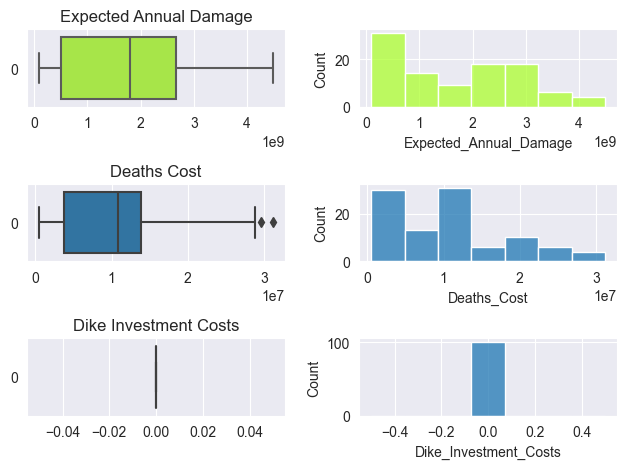

In [19]:
fig, axes = plt.subplots(3,2)

# Expected Annual Damage boxplot
sns.boxplot(
    ax=axes[0,0],
    data=total_values['Expected_Annual_Damage'],
    orient='h',
    color='greenyellow',
).set(title='Expected Annual Damage')

# Deaths_Cost boxplot
sns.boxplot(
    ax=axes[1,0],
    data=total_values['Deaths_Cost'],
    orient='h',
).set(title='Deaths Cost')

# Dike Investment Costs boxplot
sns.boxplot(
    ax=axes[2,0],
    data=total_values['Dike_Investment_Costs'],
    orient='h',
).set(title='Dike Investment Costs')

# Expected Annual Damage histogram
sns.histplot(
    ax=axes[0,1],
    data=total_values['Expected_Annual_Damage'],
    bins=7,
    color='greenyellow',
)

# Dike Investment Costs histogram
sns.histplot(
    ax=axes[2,1],
    data=total_values['Dike_Investment_Costs'],
    bins=7,
)

# Deaths_Cost histogram
sns.histplot(
    ax=axes[1,1],
    data=total_values['Deaths_Cost'],
    bins=7,
)

plt.tight_layout()

## Total cost
The total cost is also represented in both a histogram and boxplot

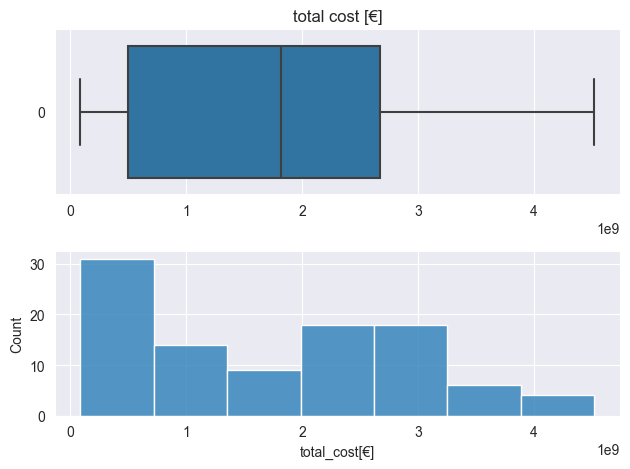

In [20]:
fig, axes = plt.subplots(2)

sns.boxplot(
    ax=axes[0],
    data=results['total_cost[€]'],
    orient='h',
).set(title='total cost [€]')

sns.histplot(
    ax=axes[1],
    data=results['total_cost[€]'],
    bins=7,
)

plt.tight_layout()

### preparations for the visualisations

In [21]:
x = results.iloc[:,:19]  # Only take the uncertainties

y_death_cost = total_values['Deaths_Cost'].values
y_death_cost = y_death_cost > np.percentile(y_death_cost, 75)
y_dama = total_values['Expected_Annual_Damage'].values
y_dama = y_dama > np.percentile(y_dama, 75)
y_invest = total_values['Dike_Investment_Costs'].values
y_invest = y_invest > np.percentile(y_invest, 75)


## Death cost visualisation

[MainProcess/INFO] 100 points remaining, containing 25 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.09, coverage: 0.36, density: 1.0 restricted_dimensions: 10


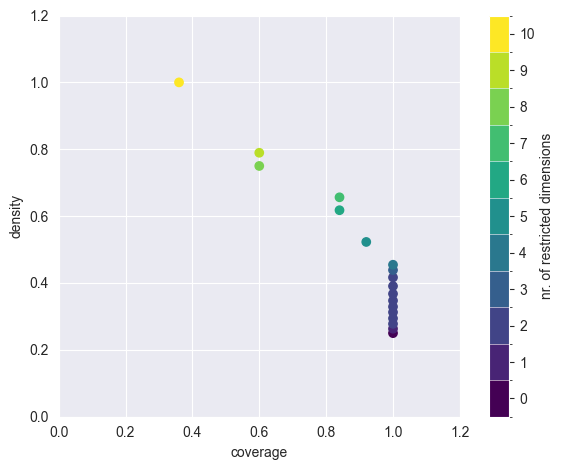

In [22]:
prim_alg_DC = prim.Prim(x,
                     y_death_cost,
                     threshold=0.75,
                     peel_alpha=0.05,) # deze variabelen nog tweaken
box_DC = prim_alg_DC.find_box()

box_DC.show_tradeoff()
plt.tight_layout()


coverage     0.36
density      1.00
id          17.00
mass         0.09
mean         1.00
res_dim     10.00
Name: 17, dtype: float64

                                  box 17                                     
                                     min              max  qp value  qp value
A.3_pfail                        0.00985         0.642013       NaN  0.001953
A.2_pfail                        0.00231          0.95025       NaN  0.164304
A.1_pfail                       0.006175         0.976466       NaN  0.387420
A.4_Bmax                       32.808663       340.144722       NaN  0.387420
A.4_pfail                       0.005938         0.961643       NaN  0.387420
discount rate 1          {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.036534       NaN
discount rate 0          {2.5, 3.5, 4.5}  {2.5, 3.5, 4.5}  0.043510       NaN
discount rate 2          {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.061336       NaN
A.5_Brate                    {1.5, 10.0}      {1.5, 10.0}  0.119135       NaN
A.0_ID f

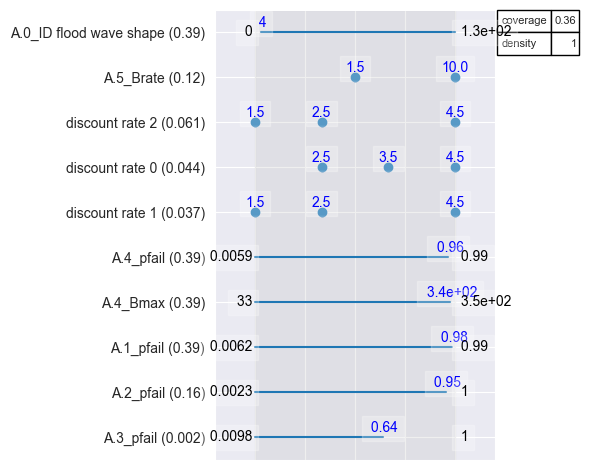

In [23]:
box_DC.inspect()
box_DC.inspect(style='graph')
plt.tight_layout()

C:\Users\beren\Documents\TU_Delft\M_Jaar_1\Q4\Model_based_decision_making\mbd_venv\Lib\site-packages\ema_workbench\analysis\scenario_discovery_util.py:413: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels)


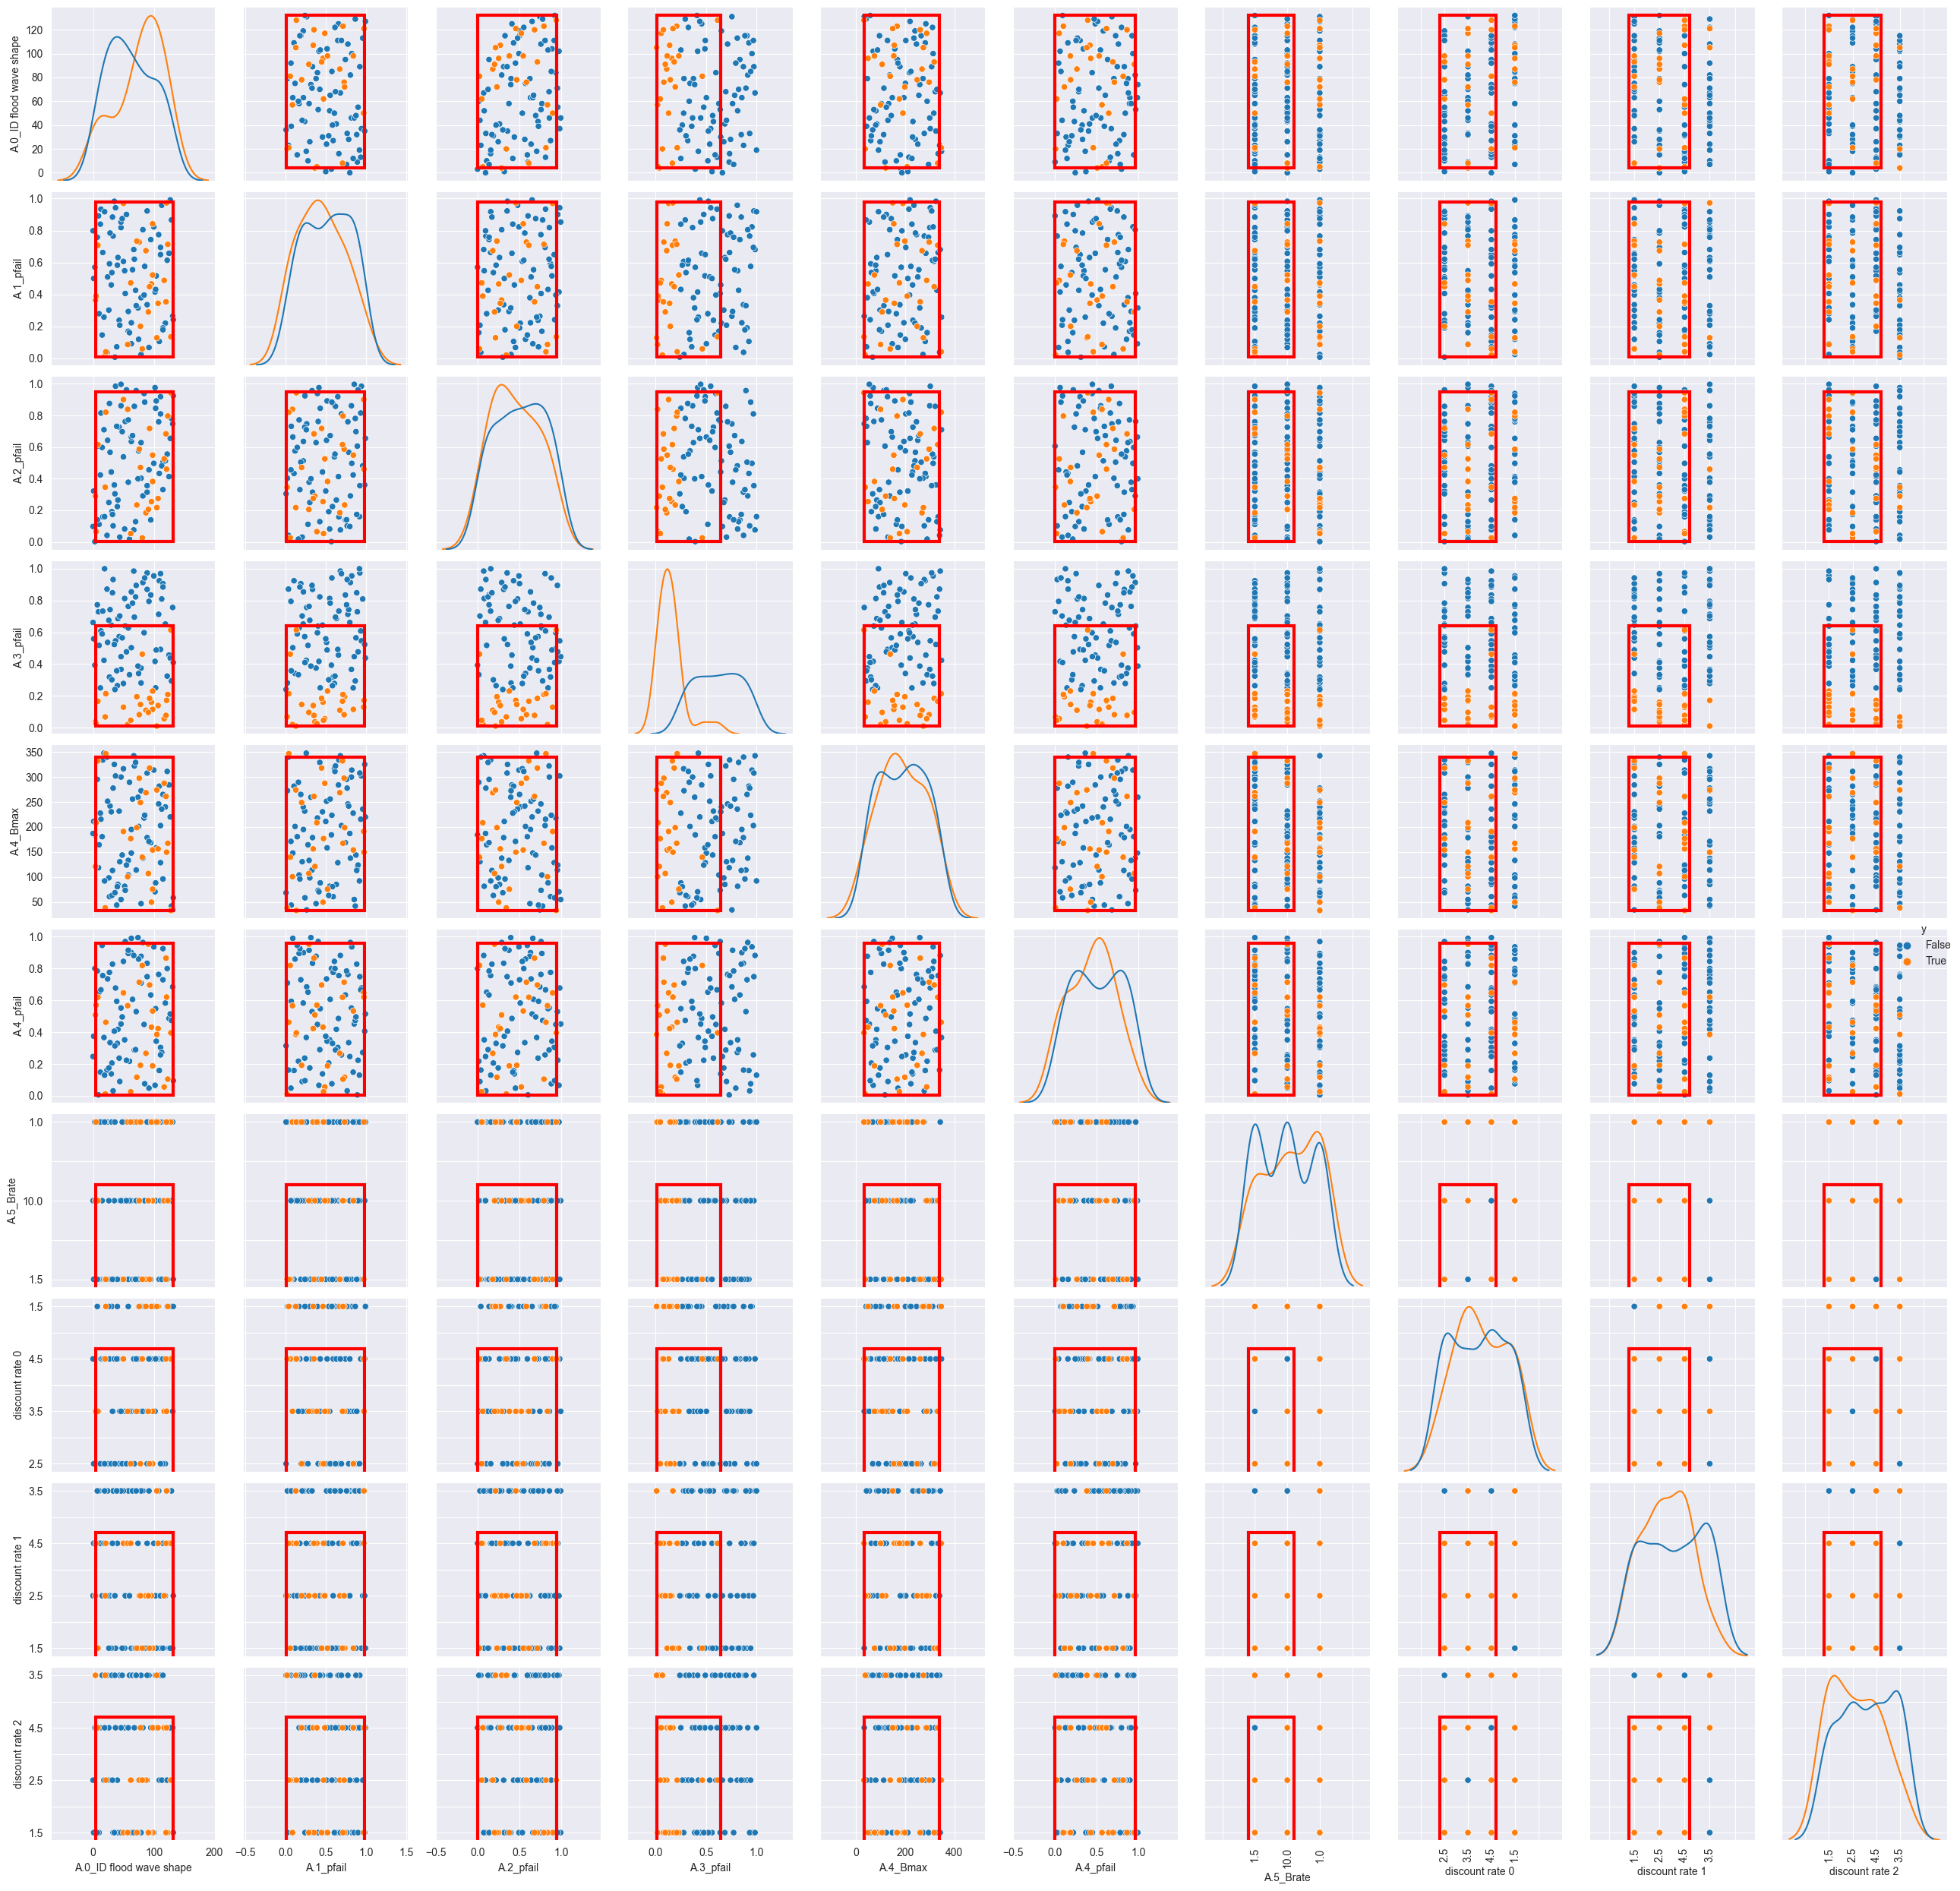

In [24]:
box_DC.select(-1)
box_DC.show_pairs_scatter()
fig = plt.gcf()
plt.tight_layout()


## Expected annual damages visualisation

[MainProcess/INFO] 100 points remaining, containing 25 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.11, coverage: 0.44, density: 1.0 restricted_dimensions: 9


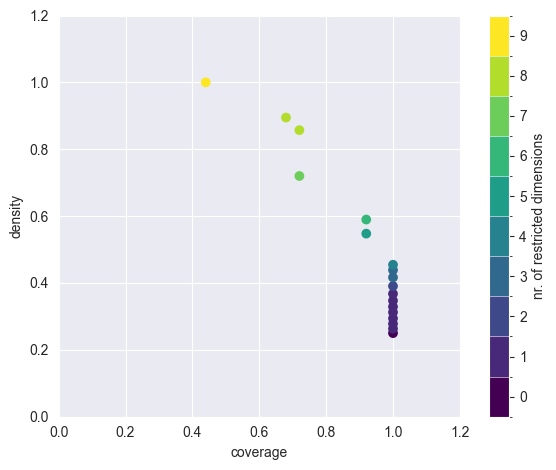

In [25]:
prim_alg_DAM = prim.Prim(x,
                     y_dama,
                     threshold=0.75,
                     peel_alpha=0.05,) # deze variabelen nog tweaken
box_DAM = prim_alg_DAM.find_box()

box_DAM.show_tradeoff()
plt.tight_layout()

coverage     0.44
density      1.00
id          17.00
mass         0.11
mean         1.00
res_dim      9.00
Name: 17, dtype: float64

                                  box 17                                     
                                     min              max  qp value  qp value
A.1_pfail                       0.006175         0.677108       NaN  0.004439
A.2_pfail                        0.00231          0.93141       NaN  1.000000
discount rate 0          {1.5, 2.5, 3.5}  {1.5, 2.5, 3.5}  0.016218       NaN
A.1_Brate                    {10.0, 1.5}      {10.0, 1.5}  0.027886       NaN
A.5_Bmax                       53.412097       348.906948  0.159200       NaN
A.5_Brate                    {10.0, 1.0}      {10.0, 1.0}  0.294204       NaN
discount rate 1          {1.5, 2.5, 4.5}  {1.5, 2.5, 4.5}  0.383995       NaN
A.1_Bmax                       36.922424       321.731884  0.414588  0.159200
A.0_ID flood wave shape                4              132  1.000000       NaN



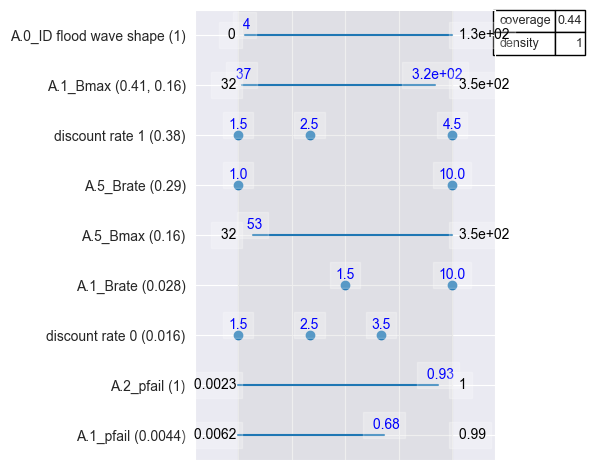

In [26]:
box_DAM.inspect()
box_DAM.inspect(style='graph')
plt.tight_layout()


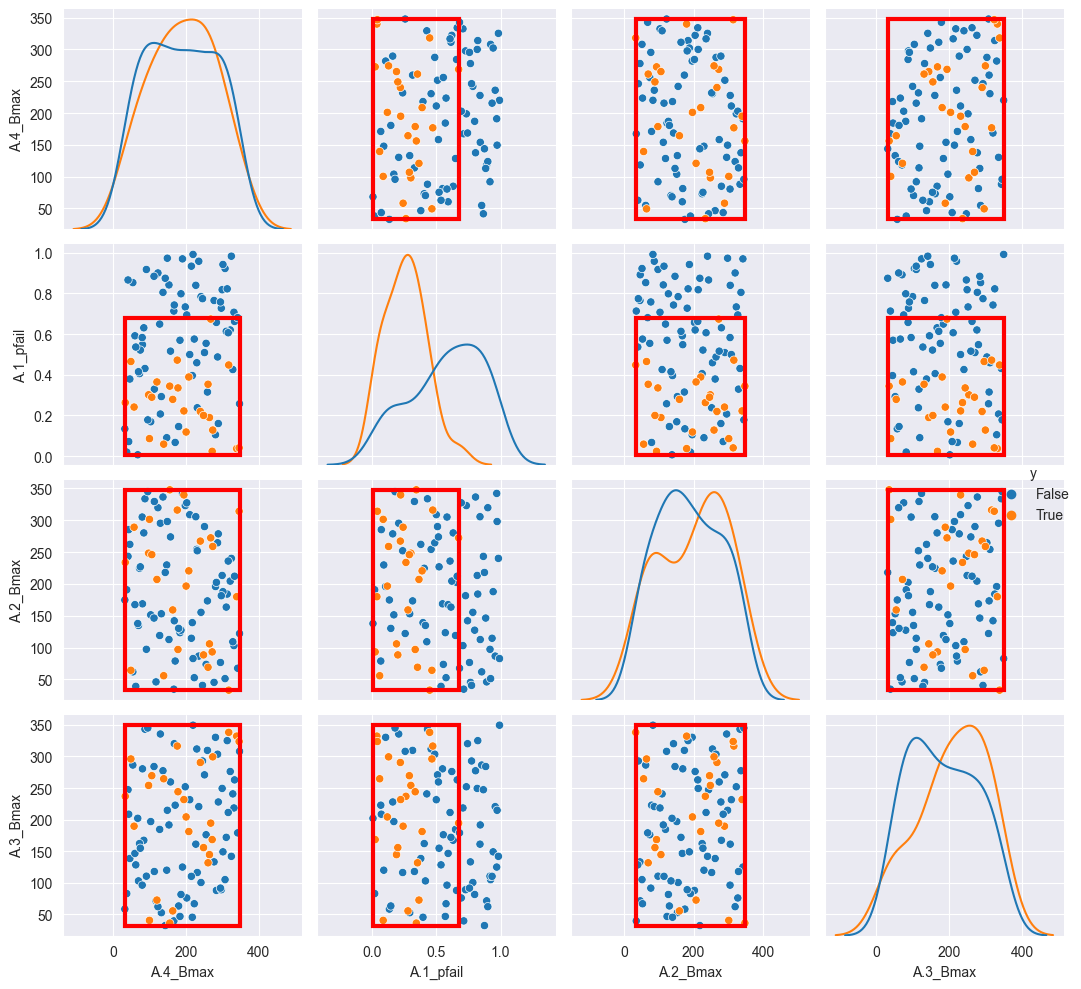

In [27]:
box_DAM.select(-1)
box_DAM.show_pairs_scatter(dims=["A.4_Bmax","A.1_pfail","A.2_Bmax","A.3_Bmax"])
fig_DAM = plt.gcf()
plt.tight_layout()


## Investment costs visualisation
As discussed previously the investment costs are irrelevant for the basecase, but will prove
to be usefull in the future, hence they are included but not used.

In [28]:
# prim_alg_INV = prim.Prim(x,
#                      y_invest,
#                      threshold=0.75,
#                      peel_alpha=0.05,) # deze variabelen nog tweaken
# box_INV = prim_alg_INV.find_box()
#
# box_INV.show_tradeoff()
# plt.tight_layout()

In [29]:
# box_INV.inspect()
# box_INV.inspect(style='graph')
# plt.tight_layout()


In [30]:
# box_INV.select(-1)
# box_INV.show_pairs_scatter()
# fig_INV = plt.gcf()
# plt.tight_layout()

# CART charts

### CART chart death cost

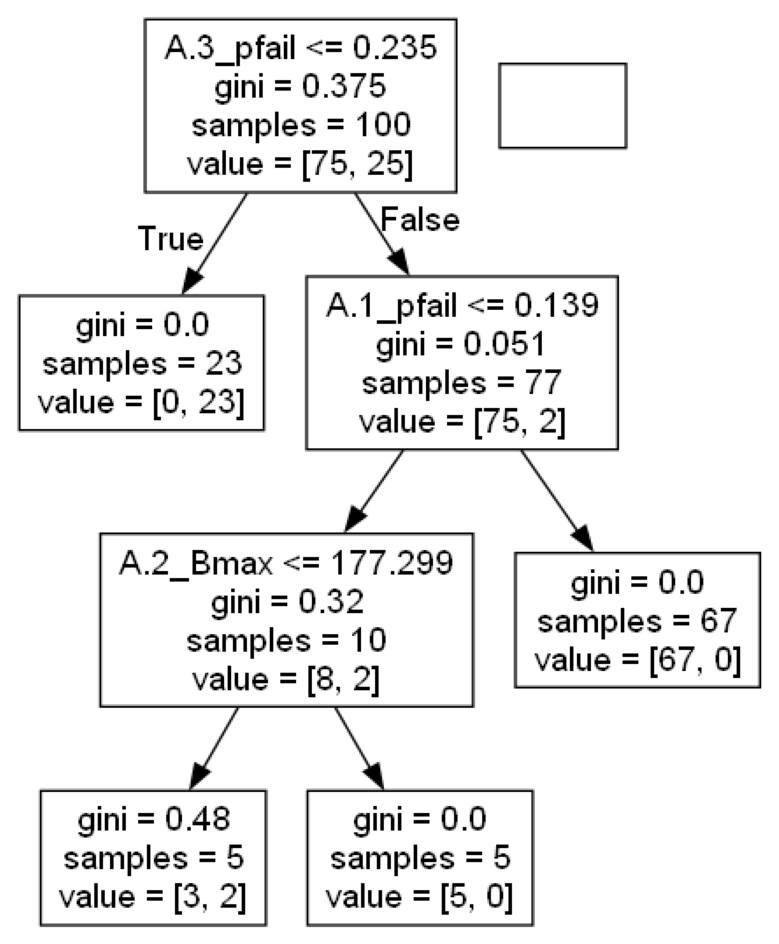

In [31]:
cart_plot = cart.CART(x, y_death_cost, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()

### CART chart expected annual damages

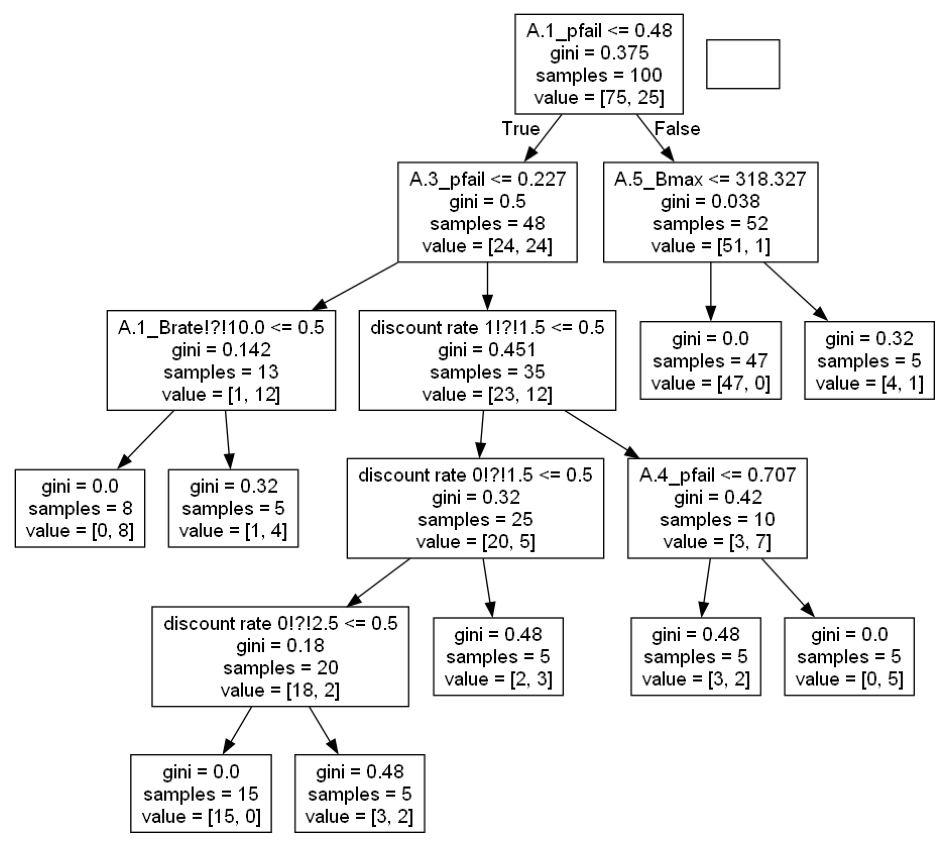

In [32]:
cart_plot = cart.CART(x, y_dama, 0.05)
cart_plot.build_tree()

# Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
fig = cart_plot.show_tree()
fig.set_size_inches(12, 12)
plt.show()

### CART chart investment costs
once again, irrelevant at thuis moment

In [33]:
# plt.show()
# cart_plot = cart.CART(x, y_invest, 0.05)
# cart_plot.build_tree()
#
# # Make sure to have GraphViz installed for the tree to show up (https://www.graphviz.org/download/)
# fig = cart_plot.show_tree()
# fig.set_size_inches(12, 12)
# plt.show()